In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from collections import Counter
from torch.nn.functional import softmax
from torch_geometric.utils import index_to_mask
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.explain import GNNExplainer, Explainer
from sklearn.model_selection import train_test_split
from collections import defaultdict
import matplotlib.pyplot as plt

# Use CUDA by default
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)


def load_dataset(filename: str):
    # Load dataset
    data_npz = np.load(f"data/TAP-city/{filename}.npz", allow_pickle=True)
    
    # Extract node features: use only the first two columns
    x_raw = data_npz["x"][:, :2]  # assuming 0 = highway (categorical), 1 = street_count
    x_raw_tensor = torch.tensor(x_raw, dtype=torch.float)
    
    # Extract and average edge features
    edge_attr_raw = data_npz["edge_attr"][:, :9]  # only first 9 raw edge features
    edge_attr_dir = data_npz["edge_attr_dir"]     # (x, y)
    edge_attr_ang = data_npz["edge_attr_ang"]     # (min, max, pi)
    
    # Concatenate raw edge features
    full_edge_attr = np.concatenate([edge_attr_raw, edge_attr_dir, edge_attr_ang], axis=1)
    
    # Map edge features to nodes (average)
    edge_index = data_npz["edge_index"]
    node_feature_map = defaultdict(list)
    
    for i, (src, tgt) in enumerate(edge_index):
        node_feature_map[src].append(full_edge_attr[i])
        node_feature_map[tgt].append(full_edge_attr[i])
    
    edge_features_per_node = np.array([
        np.mean(node_feature_map[i], axis=0) if i in node_feature_map else np.zeros(full_edge_attr.shape[1])
        for i in range(x_raw.shape[0])
    ])
    
    # Concatenate node + aggregated edge features
    x_final = np.concatenate([x_raw, edge_features_per_node], axis=1)
    x_final_tensor = torch.tensor(x_final, dtype=torch.float)
    
    # Labels and edge_index
    y = torch.tensor(data_npz["occur_labels"], dtype=torch.long)
    edge_index_tensor = torch.tensor(data_npz["edge_index"].T, dtype=torch.long)
    
    # Final PyG graph
    data = Data(x=x_final_tensor, y=y, edge_index=edge_index_tensor)
    
    # Split into train/val/test
    all_idx = torch.arange(data.num_nodes)
    train_idx, test_idx = train_test_split(all_idx, test_size=0.2, stratify=y, random_state=42)
    train_idx, val_idx = train_test_split(train_idx, test_size=0.25, stratify=y[train_idx], random_state=42)
    
    data.train_mask = index_to_mask(train_idx, size=data.num_nodes)
    data.val_mask = index_to_mask(val_idx, size=data.num_nodes)
    data.test_mask = index_to_mask(test_idx, size=data.num_nodes)
    return data, data_npz




In [2]:
import os

def fetch_cities() -> dict[str, str]:
    cities = {}
    for file in os.listdir("data/TAP-city"):
        cities[file.split(".")[0]] = file.split(".")[0]
    return cities

In [10]:
# GCN model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x
    
    def setup(self, lr=0.001):
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        self.loss_fn = torch.nn.CrossEntropyLoss()

    def evaluate(self, data):
        self.eval()
        with torch.no_grad():
            out = self(data.x, data.edge_index)
            pred = out[data.val_mask].argmax(dim=1)
            correct = (pred == data.y[data.val_mask]).sum().item()
            acc = correct / data.val_mask.sum().item()
        return acc
    
    def train_model(self, data):
        self.train()
        self.loss_list = []
        self.val_acc_list = []
        for epoch in range(200):
            self.optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = self.loss_fn(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            self.optimizer.step()

            val_acc = self.evaluate(data)

            # Store values for plotting
            self.loss_list.append(loss.item())
            self.val_acc_list.append(val_acc)

            # Print every 10 epochs
            if epoch % 10 == 0 or epoch == 1:
                print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Val Acc: {val_acc:.4f}")

    def plot_loss_and_accuracy(self, data_name):
        if not self.loss_list or not self.val_acc_list:
            print("No loss computed yet")
            return
        plt.figure(figsize=(12, 5))

        # Loss
        plt.subplot(1, 2, 1)
        plt.plot(self.loss_list, label="Train Loss", color='blue')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training Loss Over Epochs")
        plt.grid(True)
        plt.legend()

        # Validation Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(self.val_acc_list, label="Validation Accuracy", color='green')
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Validation Accuracy Over Epochs")
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        # Create a folder for data_name
        os.makedirs(f"output/{data_name}", exist_ok=True)
        plt.savefig(f"output/{data_name}/loss_and_accuracy.png")        
        pass

    def predict(self, data):
        self.eval()
        with torch.no_grad():
            out = self(data.x, data.edge_index)
            probs = softmax(out, dim=1)
            pred = probs.argmax(dim=1)
            return pred


In [11]:
def explain(data_npz, data, model, preds):
    # Load coordinates
    coordinates = data_npz["coordinates"]
    print(len(coordinates))
    assert len(coordinates) == data.x.shape[0], "Mismatch in coordinate and node count."

    feature_names = [
        'node_highway', 'street_count',
        'edge_highway', 'edge_length', 'edge_bridge', 'edge_lanes', 'edge_oneway',
        'edge_maxspeed', 'edge_access', 'edge_tunnel', 'edge_junction',
        'edge_dir_x', 'edge_dir_y',
        'angle_min', 'angle_max', 'angle_pi'
    ]

    # Padding if your final feature count exceeds 14
    if data.x.shape[1] > len(feature_names):
        feature_names += [f"feature_{i}" for i in range(len(feature_names), data.x.shape[1])]

    # GNNExplainer
    explainer = Explainer(
        model=model,
        algorithm=GNNExplainer(epochs=30),
        explanation_type='model',
        node_mask_type='attributes',
        edge_mask_type='object',
        model_config=dict(
            mode='multiclass_classification',
            task_level='node',
            return_type='log_probs',
        ),
    )

    # For each predicted hotspot, explain and output top features
    k = 5  # top-k features to show
    print(f"\n🔍 HOTSPOT ANALYSIS (Top {k} Features Per Hotspot Node):\n")
    for node_idx in range(data.num_nodes):
        if preds[node_idx] == 1:  # predicted hotspot
            explanation = explainer(data.x, data.edge_index, index=int(node_idx))
            feat_mask = explanation.node_mask[node_idx].cpu().detach().numpy()

            # Rank top-k features
            top_k = np.argsort(-feat_mask)[:k]
            feature_scores = [(feature_names[i], feat_mask[i]) for i in top_k]

            # Output
            lat, lon = coordinates[node_idx]
            print(f"📍 Node {node_idx} | Coordinates: ({lat:.6f}, {lon:.6f})")
            for name, score in feature_scores:
                print(f"   - {name}: {score:.4f}")
            print("-" * 50)


Epoch 000 | Loss: 2.9047 | Val Acc: 0.9255
Epoch 001 | Loss: 2.8226 | Val Acc: 0.9255
Epoch 010 | Loss: 2.0784 | Val Acc: 0.9255
Epoch 020 | Loss: 1.2381 | Val Acc: 0.9255
Epoch 030 | Loss: 0.4139 | Val Acc: 0.9216
Epoch 040 | Loss: 0.3166 | Val Acc: 0.9176
Epoch 050 | Loss: 0.3571 | Val Acc: 0.9255
Epoch 060 | Loss: 0.3220 | Val Acc: 0.9176
Epoch 070 | Loss: 0.3055 | Val Acc: 0.9255
Epoch 080 | Loss: 0.2961 | Val Acc: 0.9255
Epoch 090 | Loss: 0.2901 | Val Acc: 0.9255
Epoch 100 | Loss: 0.2846 | Val Acc: 0.9255
Epoch 110 | Loss: 0.2797 | Val Acc: 0.9255
Epoch 120 | Loss: 0.2751 | Val Acc: 0.9255
Epoch 130 | Loss: 0.2708 | Val Acc: 0.9255
Epoch 140 | Loss: 0.2669 | Val Acc: 0.9255
Epoch 150 | Loss: 0.2633 | Val Acc: 0.9255
Epoch 160 | Loss: 0.2600 | Val Acc: 0.9255
Epoch 170 | Loss: 0.2569 | Val Acc: 0.9255
Epoch 180 | Loss: 0.2542 | Val Acc: 0.9255
Epoch 190 | Loss: 0.2516 | Val Acc: 0.9255
1274

🔍 HOTSPOT ANALYSIS (Top 5 Features Per Hotspot Node):

📍 Node 21 | Coordinates: (-82.448256

/var/folders/91/l_89bw4d2zbbyfzbh93br7zr0000gn/T/ipykernel_89370/3008541061.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 5))


Epoch 000 | Loss: 4.3272 | Val Acc: 0.0601
Epoch 001 | Loss: 3.4502 | Val Acc: 0.0929
Epoch 010 | Loss: 0.2450 | Val Acc: 0.9508
Epoch 020 | Loss: 0.4809 | Val Acc: 0.9508
Epoch 030 | Loss: 0.4061 | Val Acc: 0.9508
Epoch 040 | Loss: 0.2199 | Val Acc: 0.9508
Epoch 050 | Loss: 0.2229 | Val Acc: 0.9454
Epoch 060 | Loss: 0.1881 | Val Acc: 0.9508
Epoch 070 | Loss: 0.1855 | Val Acc: 0.9508
Epoch 080 | Loss: 0.1844 | Val Acc: 0.9508
Epoch 090 | Loss: 0.1814 | Val Acc: 0.9508
Epoch 100 | Loss: 0.1797 | Val Acc: 0.9508
Epoch 110 | Loss: 0.1785 | Val Acc: 0.9508
Epoch 120 | Loss: 0.1774 | Val Acc: 0.9508
Epoch 130 | Loss: 0.1764 | Val Acc: 0.9508
Epoch 140 | Loss: 0.1756 | Val Acc: 0.9508
Epoch 150 | Loss: 0.1749 | Val Acc: 0.9508
Epoch 160 | Loss: 0.1742 | Val Acc: 0.9508
Epoch 170 | Loss: 0.1737 | Val Acc: 0.9508
Epoch 180 | Loss: 0.1732 | Val Acc: 0.9508
Epoch 190 | Loss: 0.1727 | Val Acc: 0.9508
912

🔍 HOTSPOT ANALYSIS (Top 5 Features Per Hotspot Node):

📍 Node 92 | Coordinates: (-122.761370

KeyboardInterrupt: 

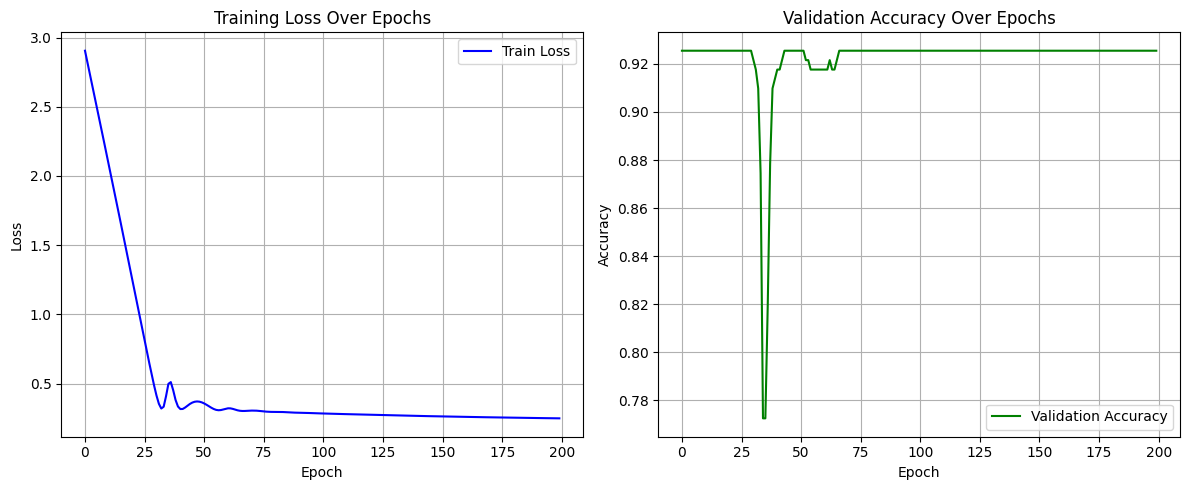

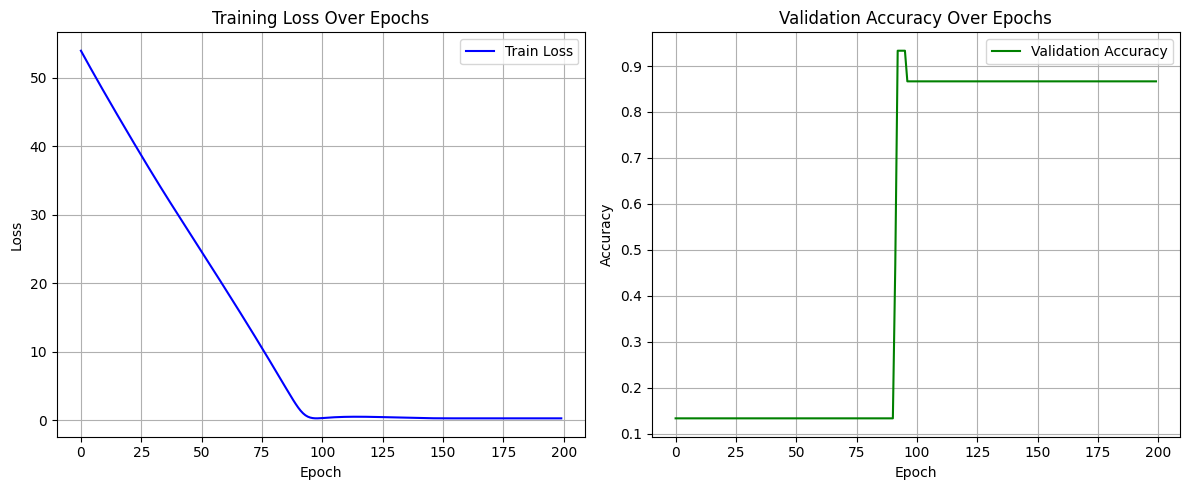

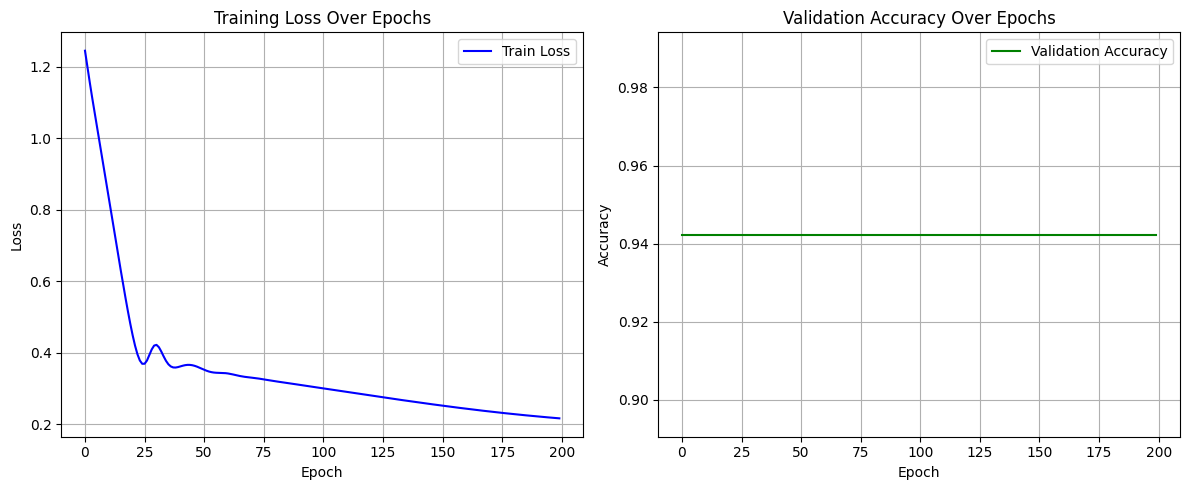

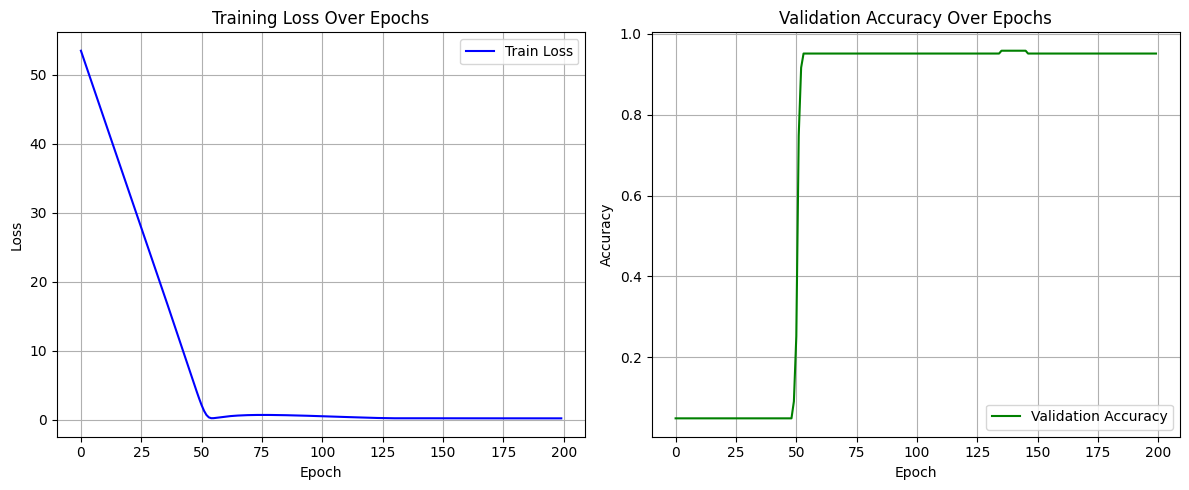

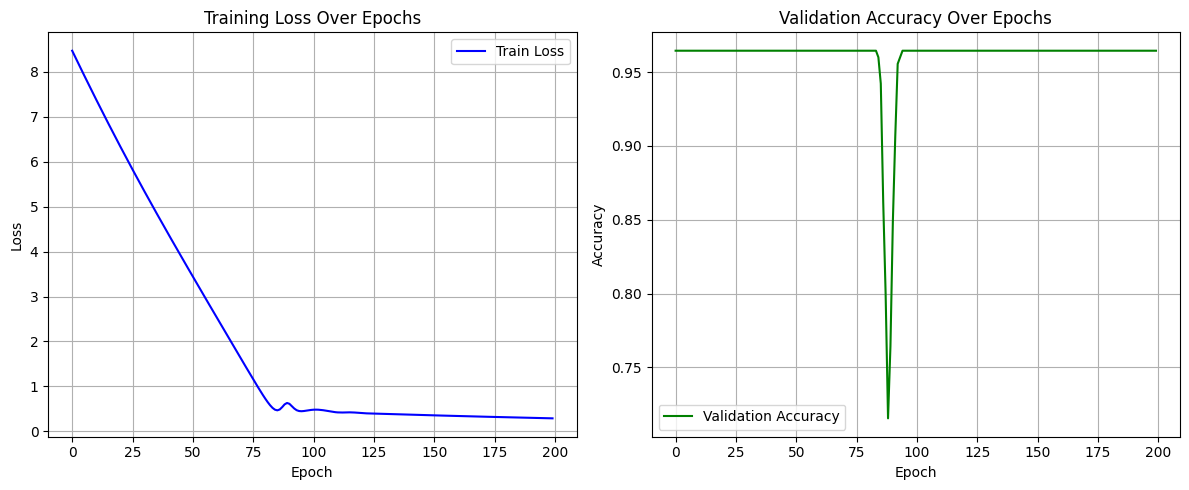

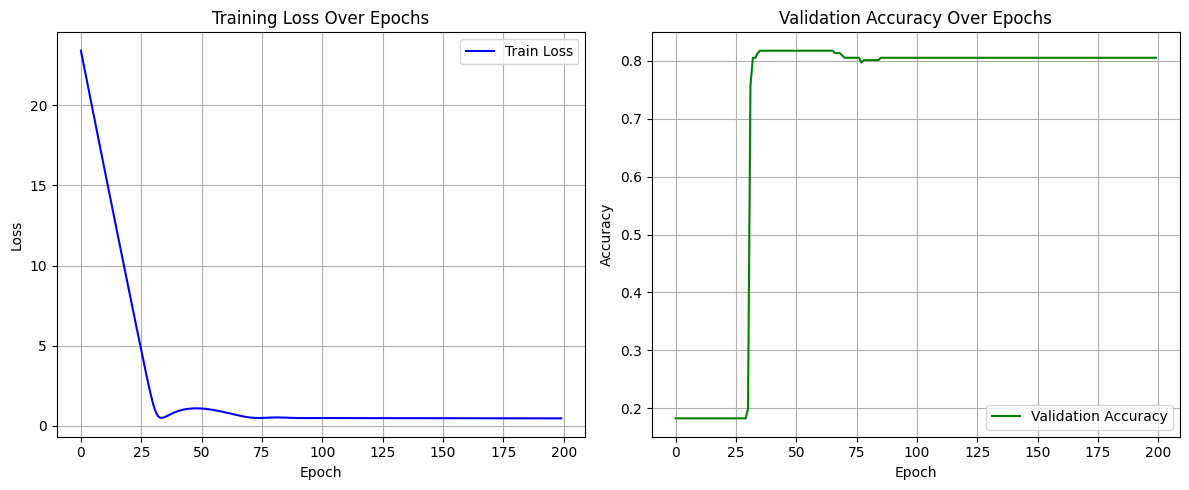

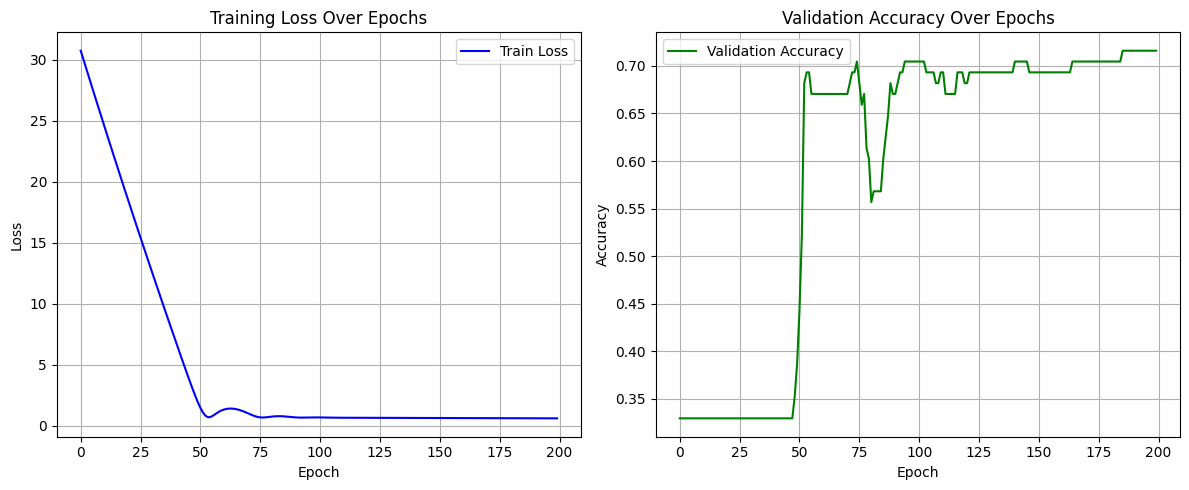

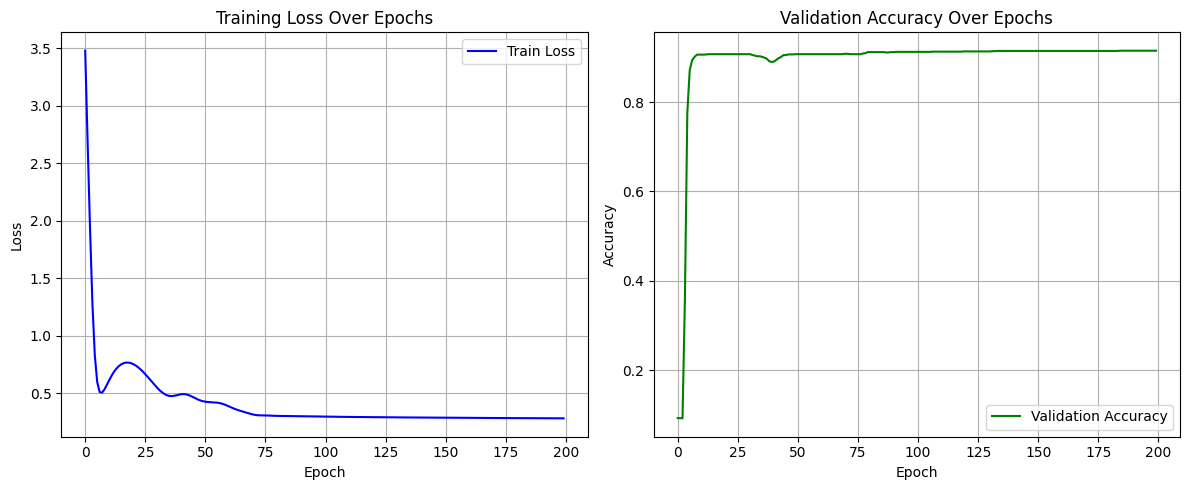

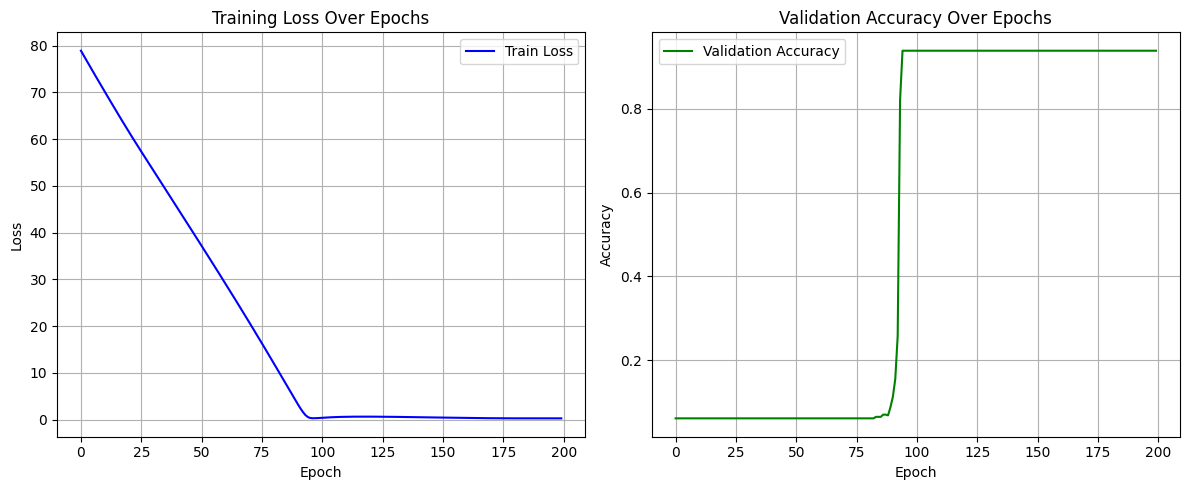

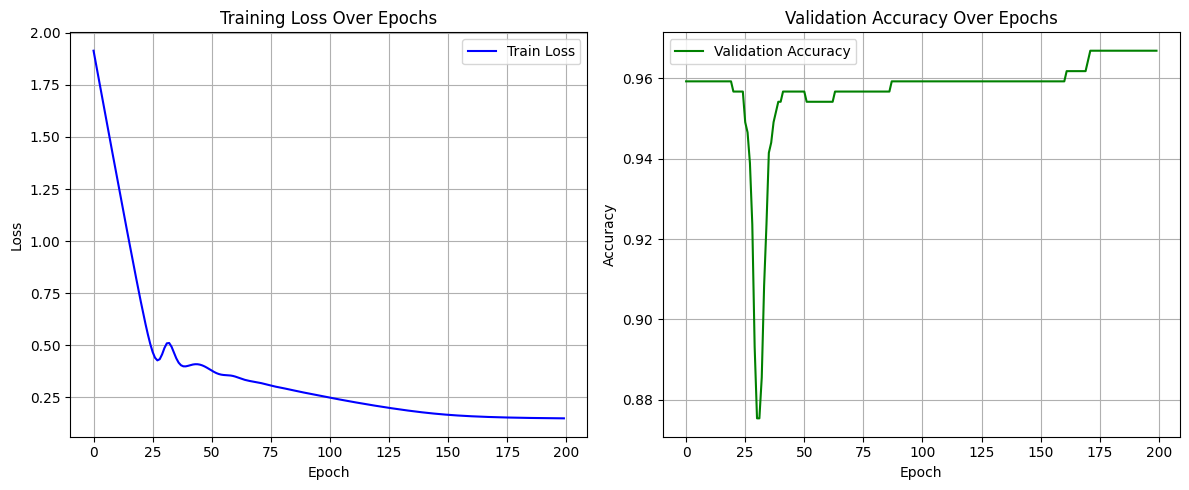

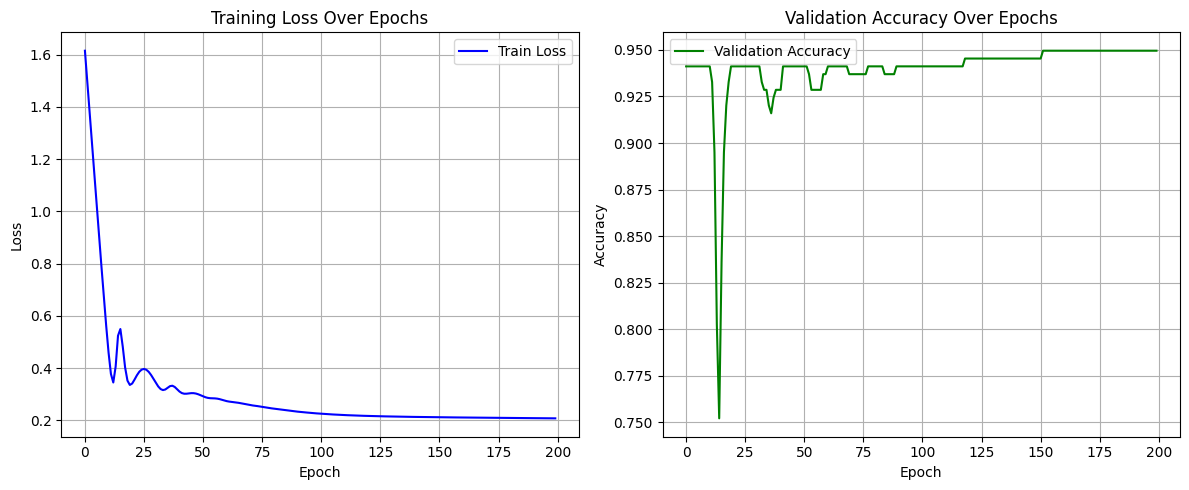

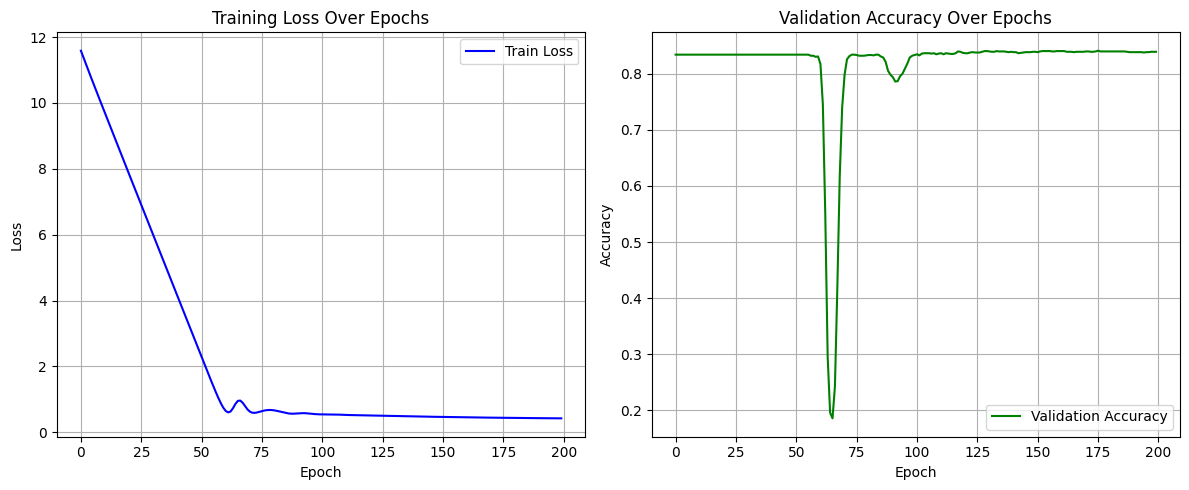

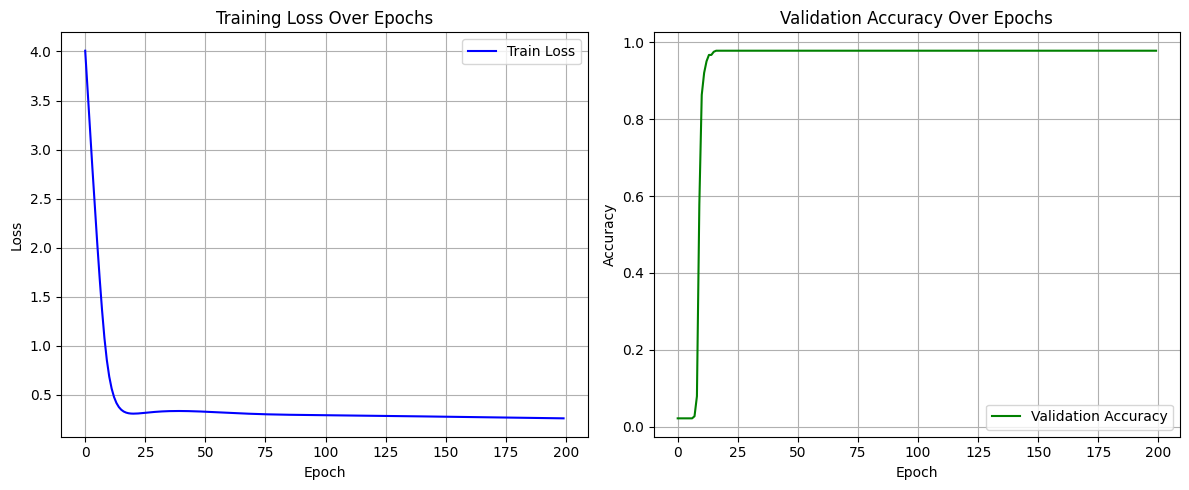

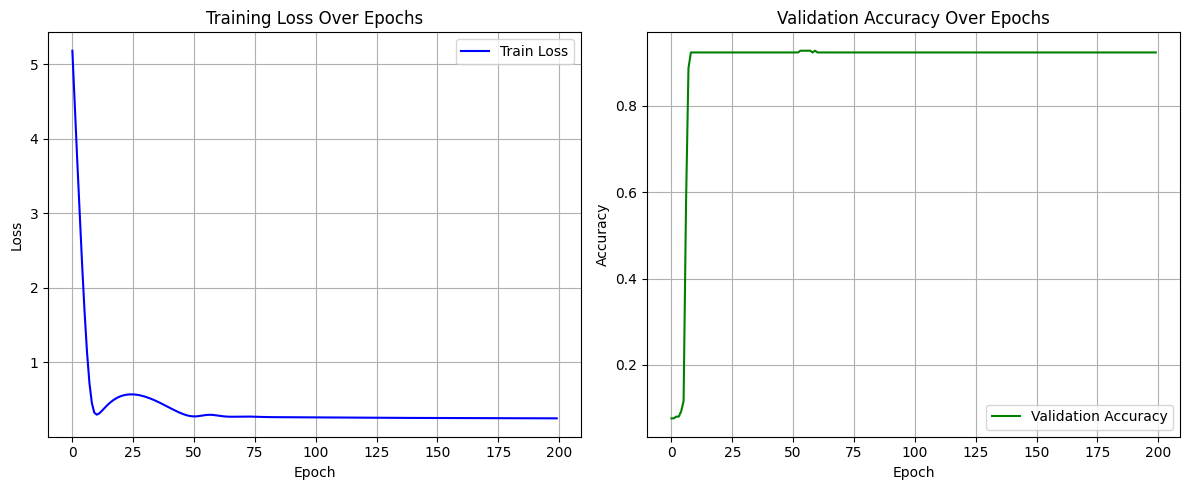

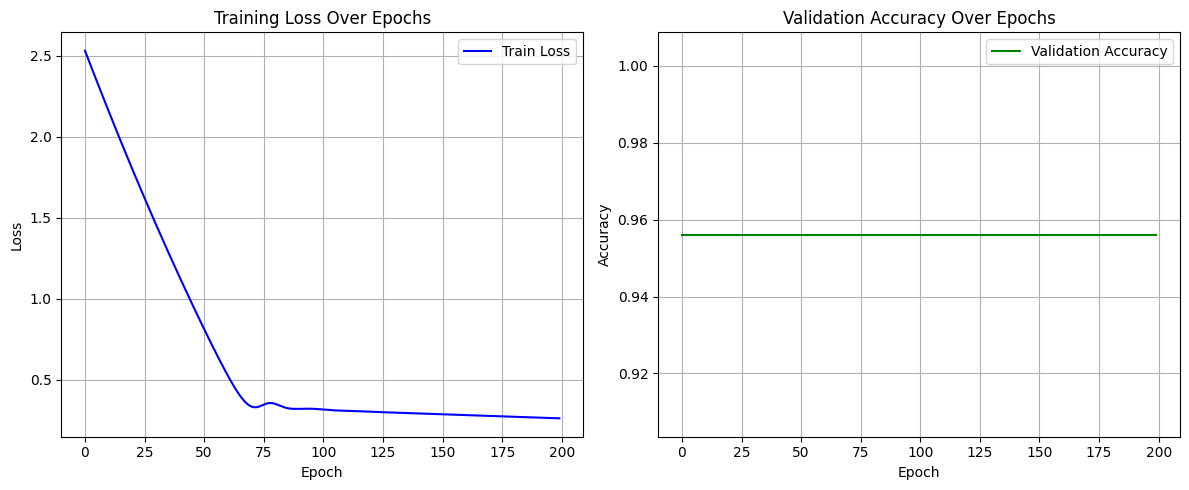

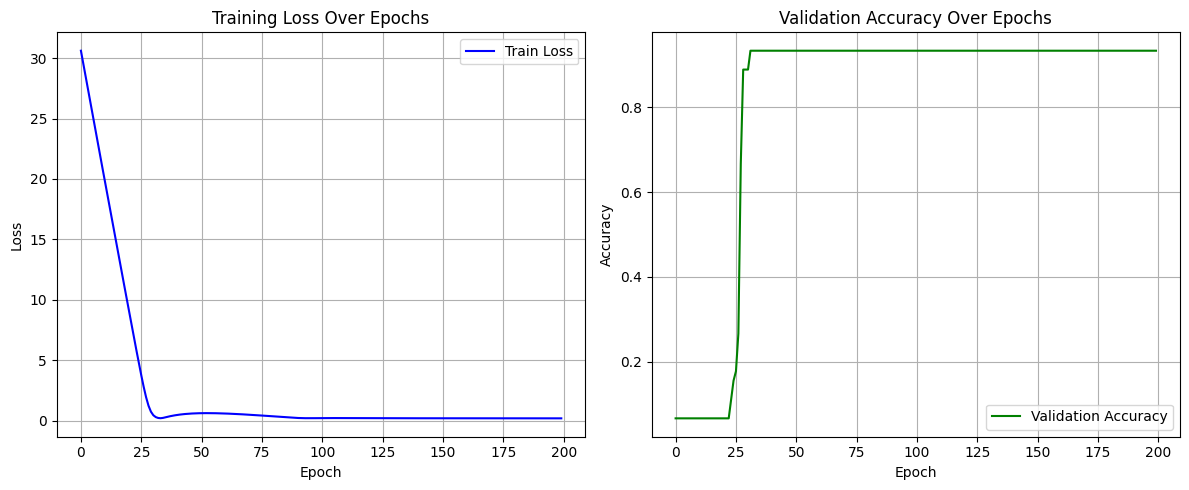

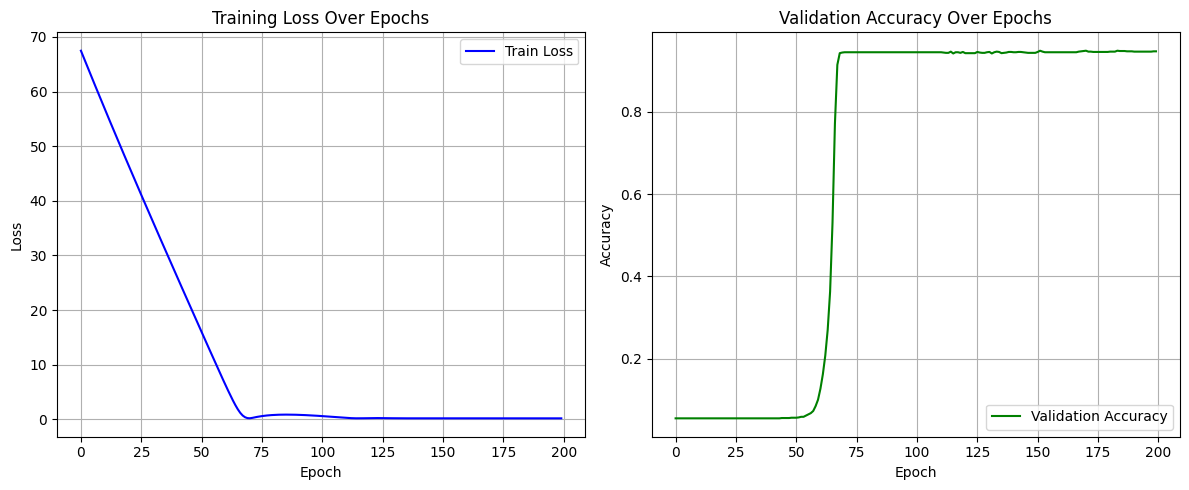

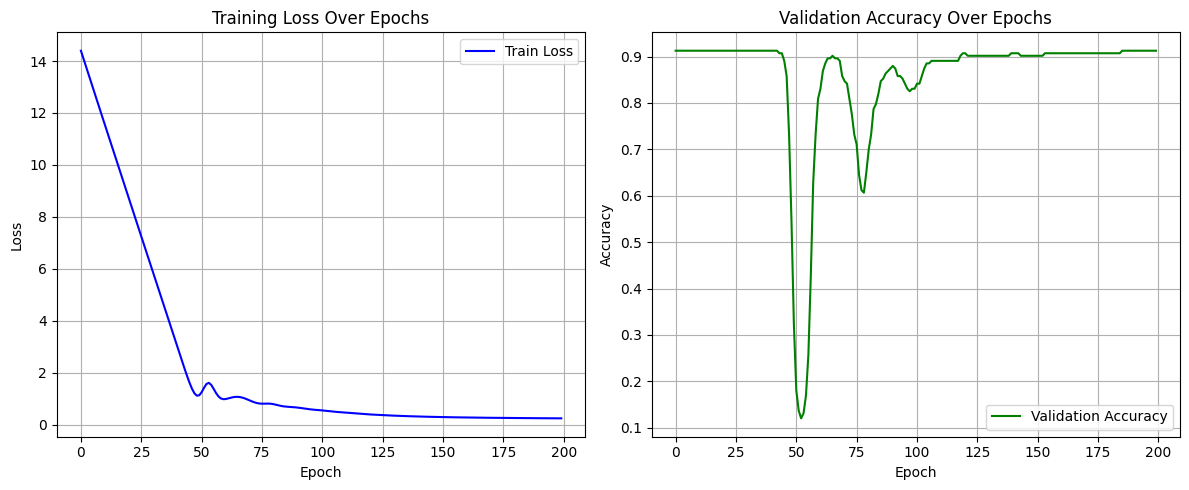

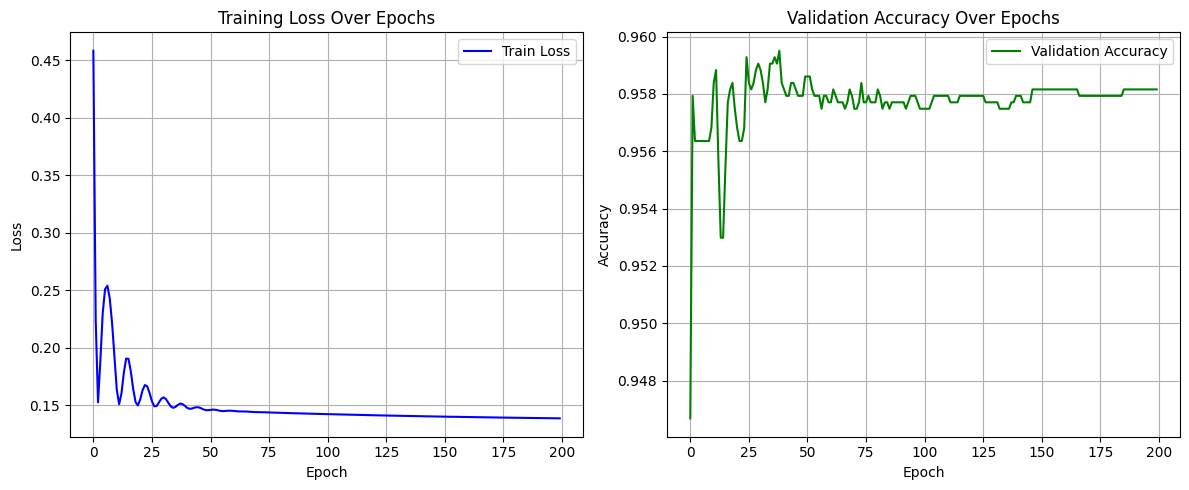

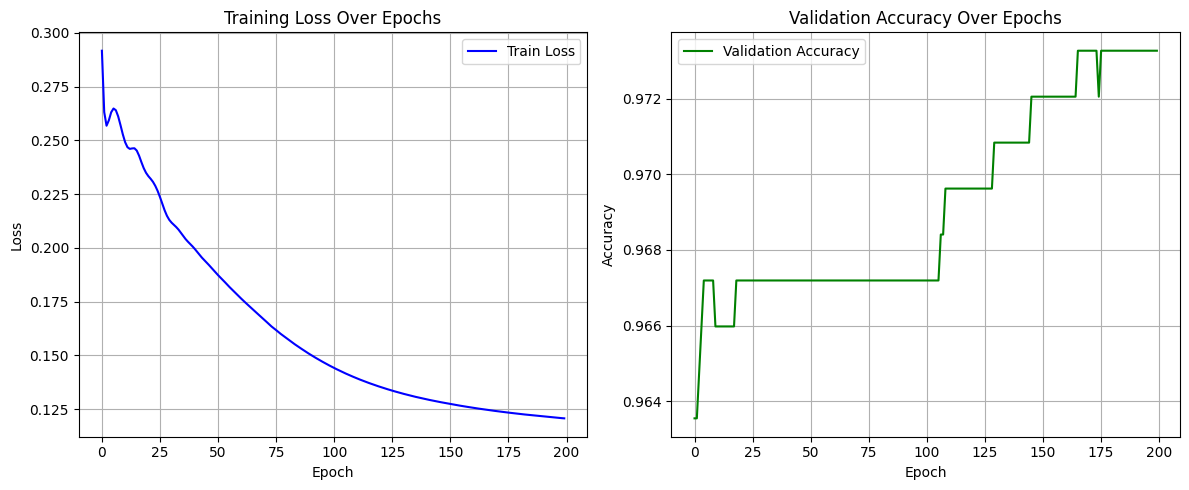

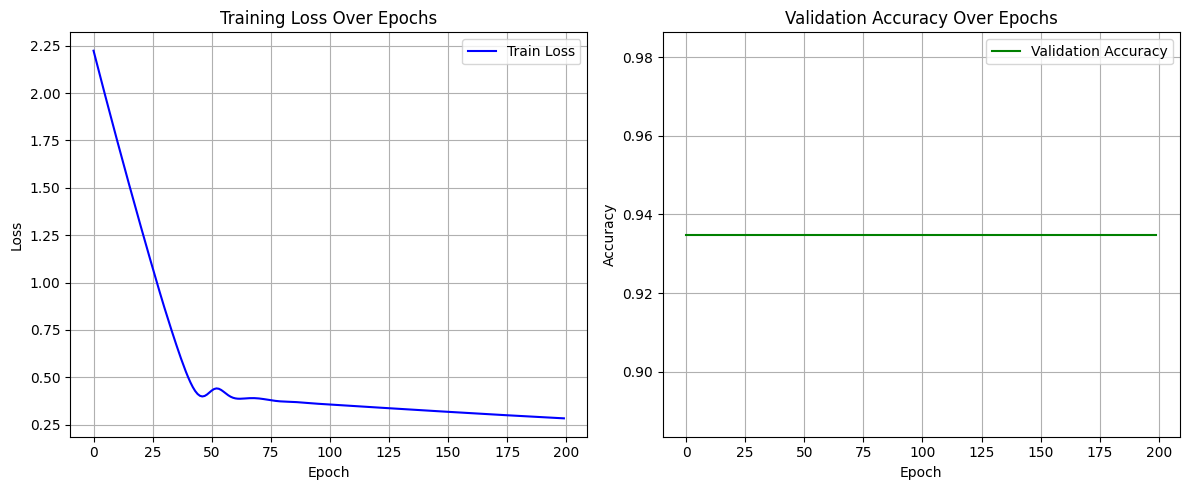

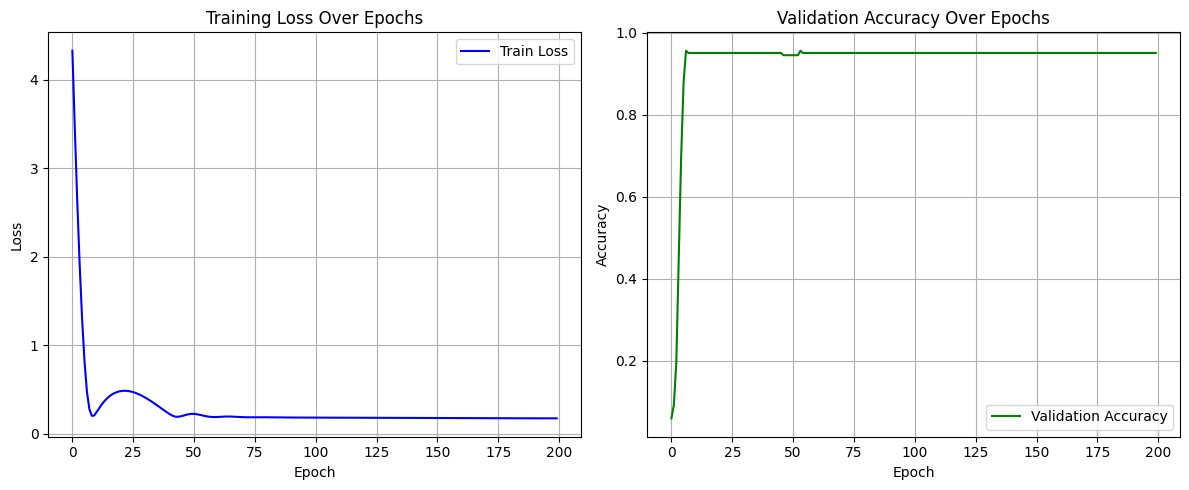

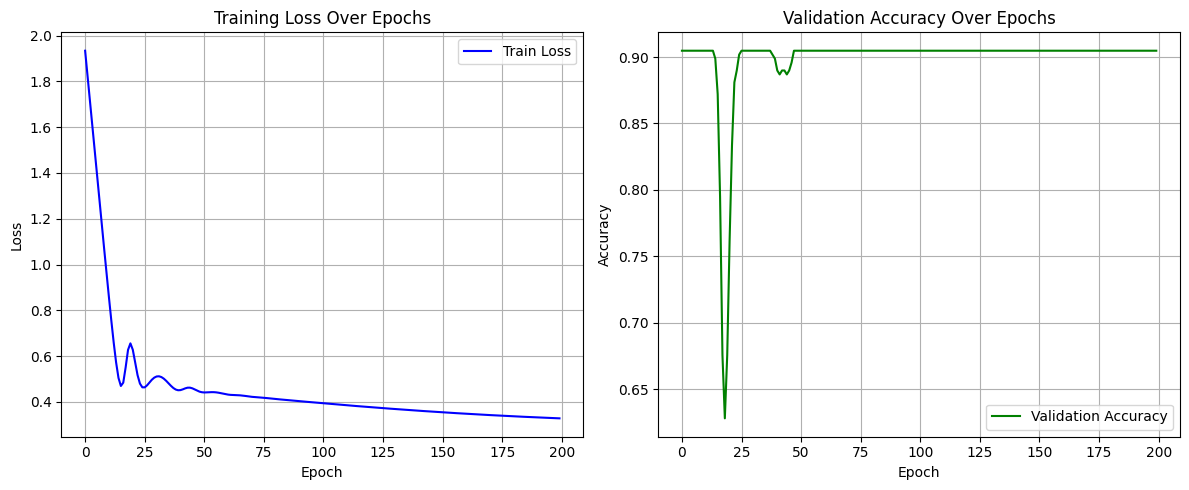

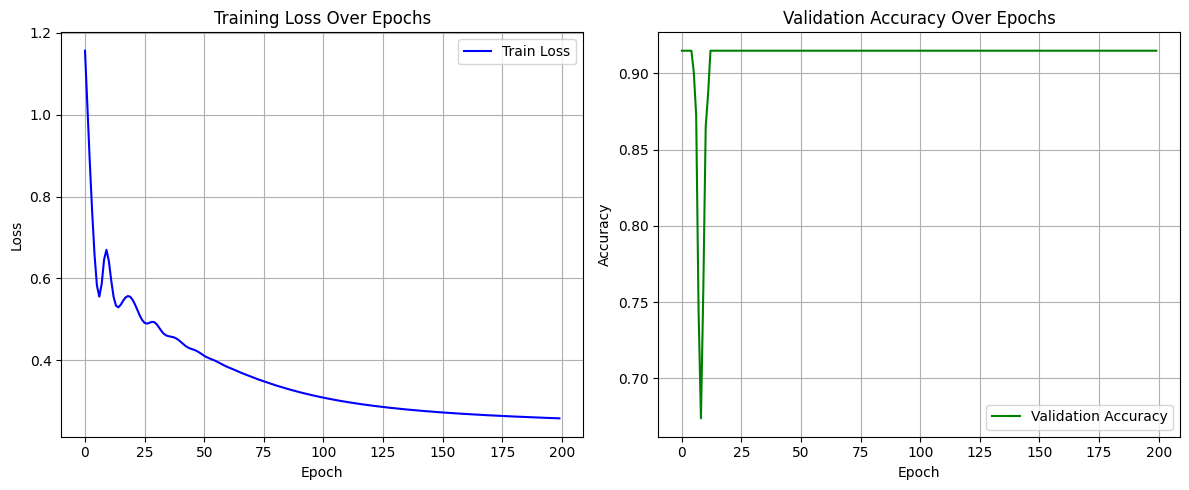

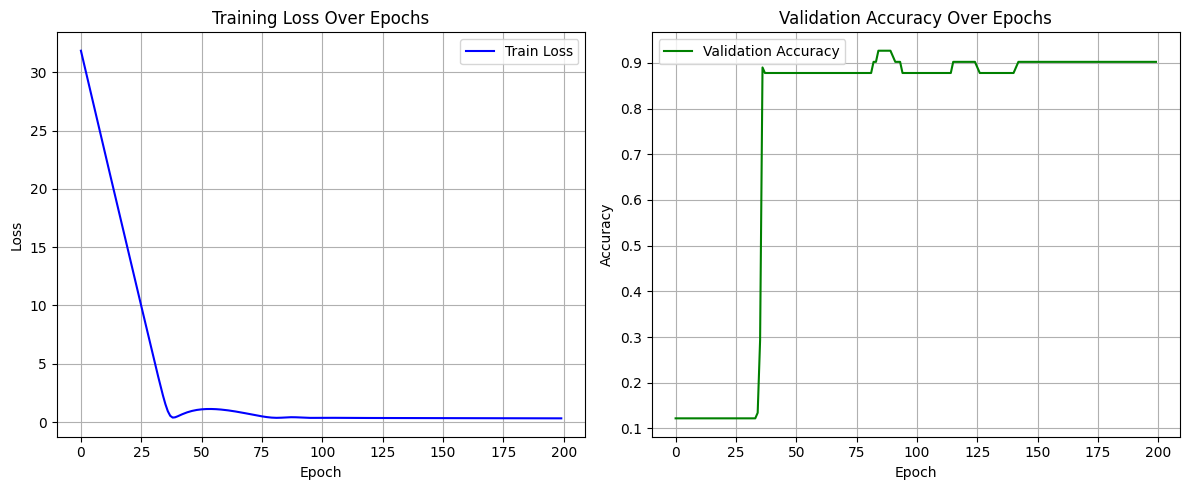

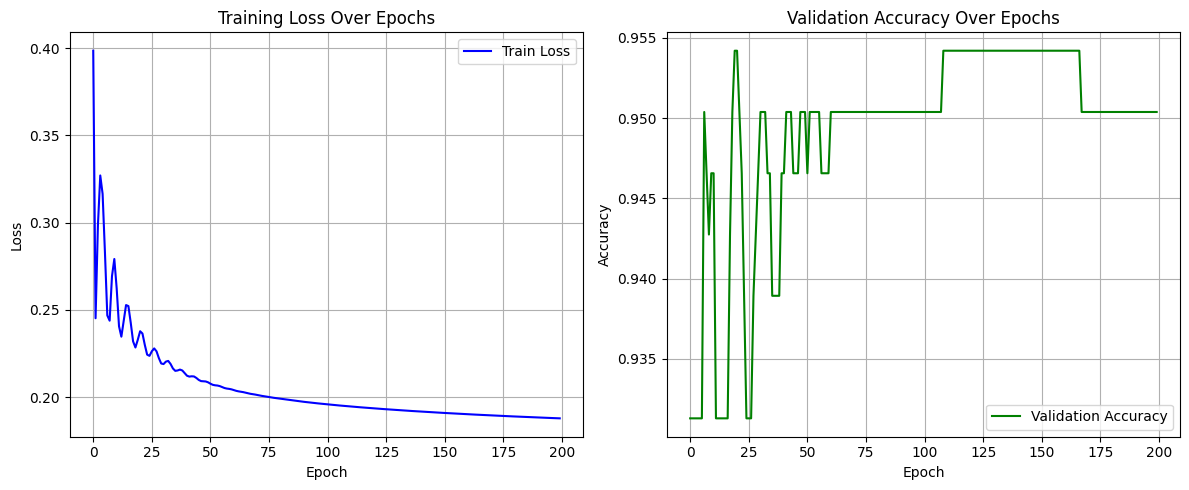

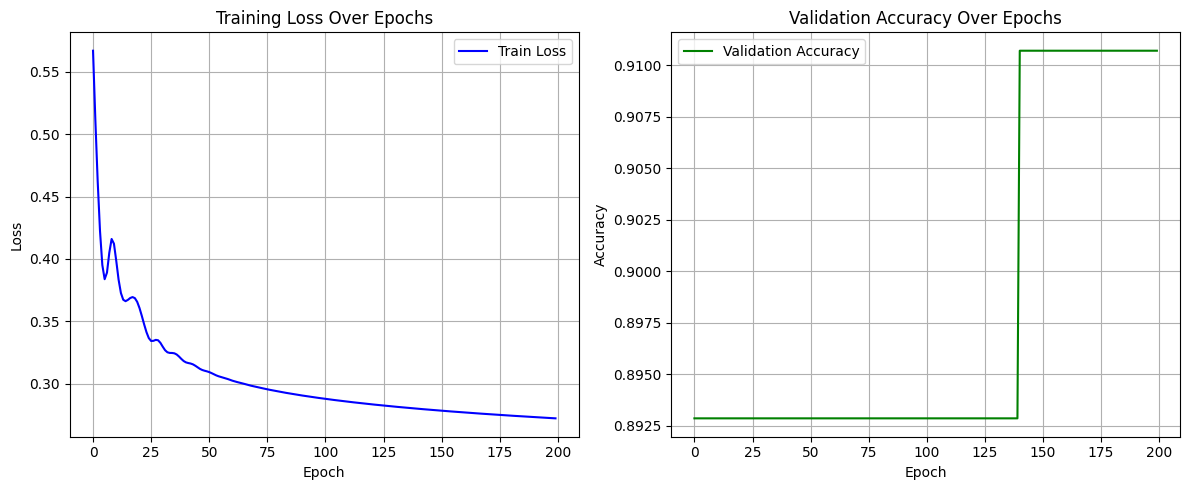

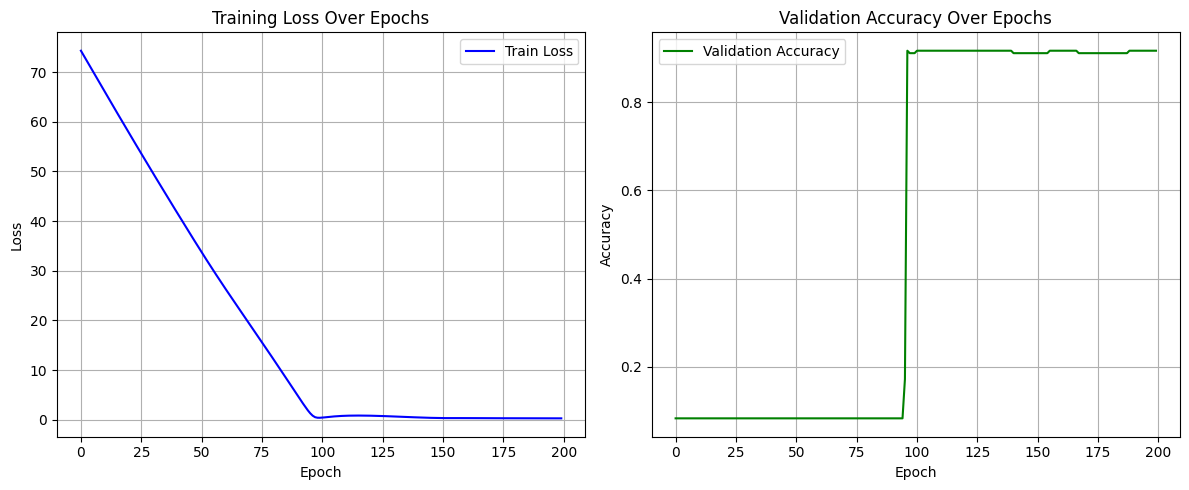

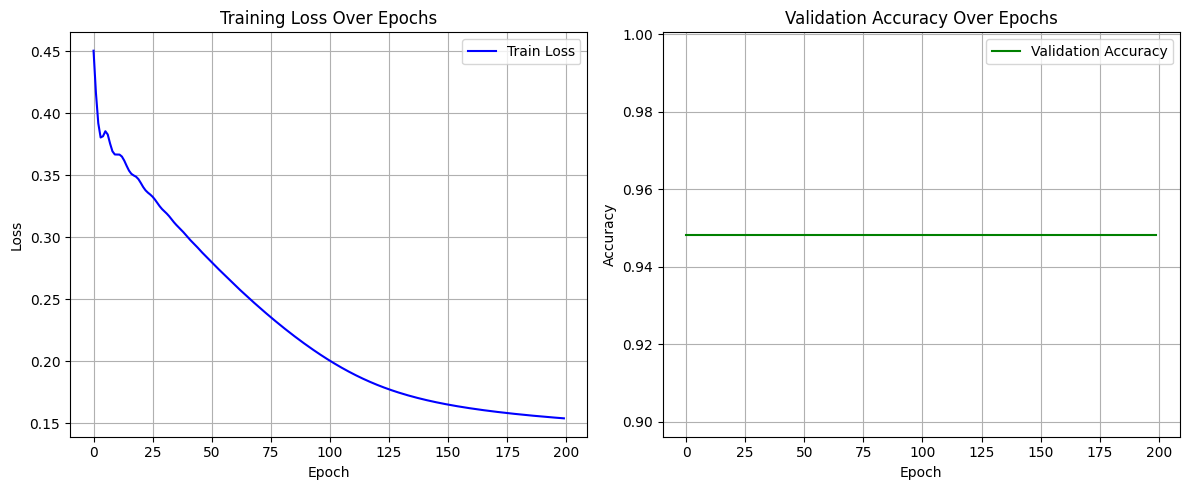

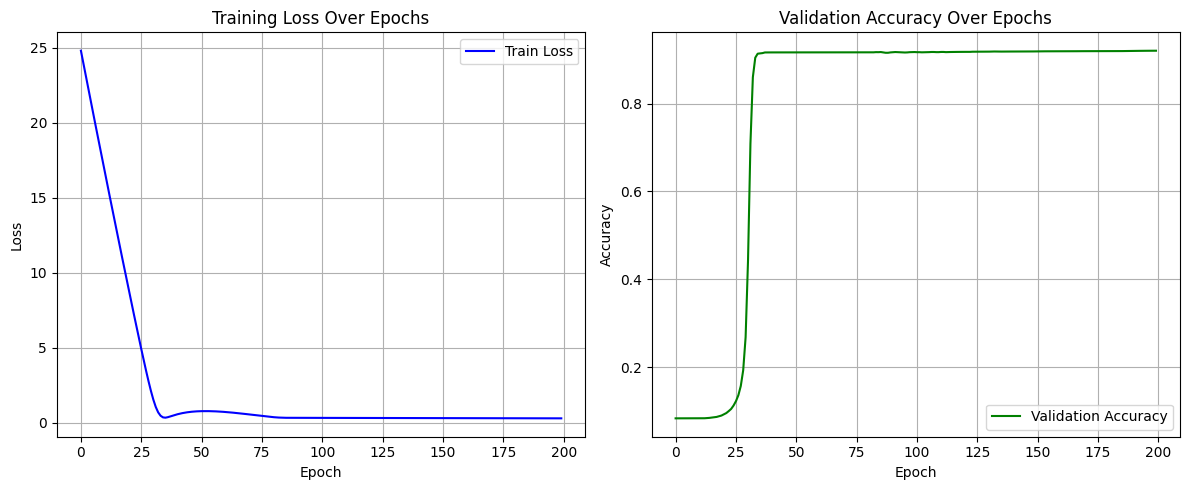

In [12]:
import pickle

cities = fetch_cities()

outputs = {}
for city_name, filename in cities.items():
    data, data_npz = load_dataset(filename)
    gcn = GCN(in_channels=data.x.shape[1], hidden_channels=16, out_channels=2)
    gcn.setup()
    gcn.train_model(data)
    gcn.plot_loss_and_accuracy(city_name)
    preds = gcn.predict(data)
    outputs[city_name] = preds
    explain(data_npz, data, gcn, preds)

    # Save the model
    os.makedirs(f"output/{city_name}", exist_ok=True)
    torch.save(gcn.state_dict(), f"output/{city_name}/model.pth")
    # Save the outputs
    with open(f"output/{city_name}/outputs.pkl", "wb") as f:
        pickle.dump(outputs, f)




In [6]:
import pickle

# Save the outputs
with open("output/outputs.pkl", "wb") as f:
    pickle.dump(outputs, f)

TypeError: Object of type Tensor is not JSON serializable

In [ ]:

#Top recurring features in hotspots
k = 5
feature_counter = Counter()

for node_idx in range(data.num_nodes):
    if preds[node_idx] == 1:  # Only for predicted hotspots
        explanation = explainer(data.x, data.edge_index, index=int(node_idx))
        feat_mask = explanation.node_mask[node_idx].cpu().detach().numpy()

        # Get top-k important feature indices
        top_k_indices = np.argsort(-feat_mask)[:k]

        # Add feature names to counter
        feature_counter.update([feature_names[i] for i in top_k_indices])

# Sort and display most frequent top features
most_common_features = feature_counter.most_common(10)
print("\nMost Common Top Features for Hotspot Predictions:")
for name, freq in most_common_features:
    print(f"{name}: {freq} times in top-{k}")


In [ ]:
def hotspot_heatmap(coordinates, preds, city_name):
  #Hotspot heatmap
  hotspot_coords = coordinates[preds == 1]
  non_hotspot_coords = coordinates[preds == 0]

  plt.figure(figsize=(10, 8))
  plt.scatter(non_hotspot_coords[:, 1], non_hotspot_coords[:, 0],
              c='skyblue', s=10, label='Non-Hotspots', alpha=0.5)
  plt.scatter(hotspot_coords[:, 1], hotspot_coords[:, 0],
              c='red', s=20, label='Hotspots', alpha=0.8)

  plt.xlabel("Longitude")
  plt.ylabel("Latitude")
  plt.title("Hotspot Prediction Map")
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.savefig(f"output/hotspot_heatmap_{city_name}.png")
  pass

In [ ]:
# Load the model and outputs
for city_name in cities.keys():
    model = GCN(in_channels=data.x.shape[1], hidden_channels=16, out_channels=2)
    model.load_state_dict(torch.load(f"output/{city_name}/model.pth"))
    with open(f"output/{city_name}/outputs.pkl", "rb") as f:
        outputs = pickle.load(f)
    for city_name, preds in outputs.items():
        hotspot_heatmap(data_npz["coordinates"], preds, city_name)
